# Clustering
* use the collected data (text and wikidata descriptions) to automatically cluster persons
    * first, using 2 clusters
    * second, using 6 clusters

* compare the results obtained when using
    * three ways of representing text (tokens, token
    * frequency and tf-idf) and 2 vs. 6 clusters.

In [40]:
import csv
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from nltk import word_tokenize
from sklearn.cluster import KMeans
from sklearn import metrics 
import numpy as np
from itertools import chain

# Visualisation
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from scipy.cluster.hierarchy import ward, dendrogram

In [41]:
with open('data/data.csv', 'r') as f:
    df = pd.read_csv(f, index_col=0)
df.head()

,person,description,p_description,content,p_content,label_2,label_6
0,Kichka_Bodurova,Bulgarian pop-folk musician,"['bulgarian', 'popfolk', 'musician']","Big Brother: All-Stars, also known as Big Brot...","[['big', 'brother', 'allstars', 'also', 'known...",A,singer
1,Taras_Topolya,Ukrainian singer,"['ukrainian', 'singer']",EdCamp Ukraine (Ukrainian: ЕдКемп Україна) is ...,"[['edcamp', 'ukraine', 'ukrainian', 'едкемп', ...",A,singer
2,Louis_Graveure,"English actor and baritone singer known as ""Th...","['english', 'actor', 'baritone', 'singer', 'kn...",The Accusing Song (German: Ein Lied klagt an) ...,"[['accusing', 'song', 'german', 'ein', 'lied',...",A,singer
3,Philippe_Robrecht,Belgian guitarist and singer,"['belgian', 'guitarist', 'singer']",Jacques Romain Georges Brel (French: [ʒɑk ʁɔmɛ...,"[['jacques', 'romain', 'georges', 'brel', 'fre...",A,singer
4,Moira_Lambert,British singer,"['british', 'singer']",Mary Rose Byrne (born 24 July 1979) is an Aust...,"[['mary', 'rose', 'byrne', 'born', '24', 'july...",A,singer


In [42]:
eval(df.p_description[0])

['bulgarian', 'popfolk', 'musician']

In [43]:
# labels
y_2 = df.label_2
y_6 = df.label_6


#data
eva = list(map(eval, df.p_description))
X_d = list(map(lambda x: ' '.join(x), eva))

eva = list(map(eval, df.p_content))
flattened_eva = list(map(lambda x: list(chain(*x)), eva))
X_c = list(map(lambda x: ' '.join(x), flattened_eva))

In [44]:
# methods
count_v = CountVectorizer()
one_hot = OneHotEncoder(categories=[t for description in df.p_description for t in description])
tfidf = TfidfVectorizer(max_features = 20,
                                use_idf = True,
                                stop_words = 'english',
                                tokenizer = word_tokenize)

methods = {'tfidf':tfidf, 'count_v':count_v} #'one_hot':one_hot

# number of clusters
cluster_numbers =  [2,6]
labels_n_clusters = [(2, y_2), (6, y_6)]

## Part 1
Define a function to train a clustering algorithm on some data using N clusters and some input representation method M (tokens, token frequency and tf-idf).
Data, M and N should be parameters of that function.

In [45]:
def train_cluster(data, n_clusters, method = tfidf):
    vectorised_input = method.fit_transform(data)

    km = KMeans(n_clusters)
    km.fit(vectorised_input)
    return km, vectorised_input

In [46]:
clusters, vectorised_input = train_cluster(data=X_d, n_clusters=2, method = tfidf)

## Part 2
Define a function to compute both intrinsic (Silhouette coefficient) and extrinsic (homogeneity, completeness, v-measure, adjusted Rand index) evaluation scores for clustering results.

In [47]:
def compute_scores(labels, clustering, vectorised_input):
    # When a ground truth is available 

    homo = (metrics.homogeneity_score(labels, clustering)) 
    comp = (metrics.completeness_score(labels, clustering)) 
    v_m = (metrics.v_measure_score(labels, clustering)) 
    ari = (metrics.adjusted_rand_score(labels, clustering)) 

    # When no ground truth is available 

    silh = (metrics.silhouette_score(vectorised_input, clustering, sample_size=1000))

    return homo, comp, v_m, ari, silh
    

In [48]:
compute_scores(labels=y_2, clustering=clusters.labels_, vectorised_input=vectorised_input)
#	2	tfidf	0.148189	0.261583	0.189197	0.068706	0.040668

(0.13216336409604673,
 0.2167179884207683,
 0.1641943784223112,
 0.07452366180212745,
 0.14237244954362455)

In [49]:
metric_names = 'homogeneity, completeness, v_measure, adjusted_rand_index, silhouette_coef'.split(', ')

In [51]:
#Create dataframe with scores


data = pd.DataFrame(columns=['n_clusters','method',*metric_names])

for n_clusters, labels in labels_n_clusters:
    for name,method in methods.items():

        clusters, vectorised_input = train_cluster(data=X_d,                                           
                                                    n_clusters=n_clusters,
                                                    method=method)
        scores = compute_scores(labels=labels,
                                clustering=clusters.labels_,
                                vectorised_input=vectorised_input)


        new_row = []
        new_row.append(n_clusters)
        new_row.append(name)
        new_row.extend(scores)
        
        data.loc[len(data.n_clusters)] = new_row
        

In [52]:
data.head()

,n_clusters,method,homogeneity,completeness,v_measure,adjusted_rand_index,silhouette_coef
0,2,tfidf,0.132163,0.216718,0.164194,0.074524,0.142372
1,2,count_v,0.132163,0.216718,0.164194,0.074524,0.021349
2,6,tfidf,0.633189,0.676642,0.654195,0.482267,0.317671
3,6,count_v,0.522370,0.596272,0.556880,0.359909,0.099491


## Part 3
Define a function to visualise those metrics values for each of the three input representations (tokens, token frequency and tf-id) and for 2 vs. 6 clusters (so your visualisation should display 5 scores for each of the 6 clustering results)

In [53]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

In [54]:
def visualise_metrics(data, metric_names):
    sns.set_theme(style="whitegrid", color_codes=True)
    # Draw a nested barplot by number of clusters and method
    for metric_name in metric_names:
        g = sns.catplot(
            data=data, kind='bar',
            x='n_clusters', y=metric_name, hue='method',
            palette="dark", alpha=.6, height=6
        )

        g.despine(left=True)
        g.set_axis_labels("Number of Clusters", metric_name)
        g.legend.set_title("Methods")

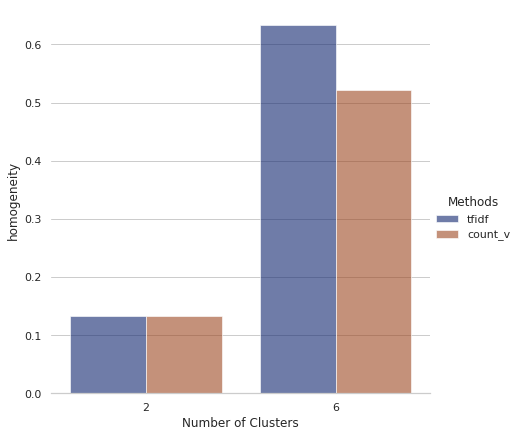

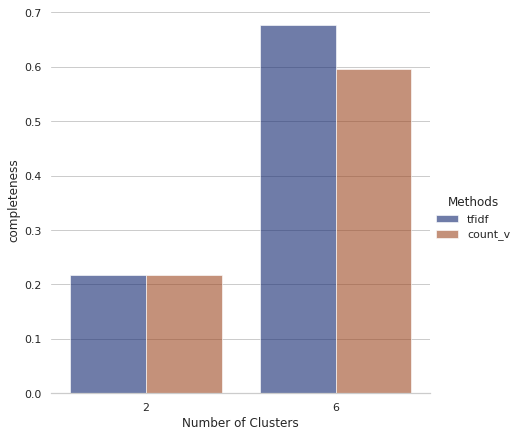

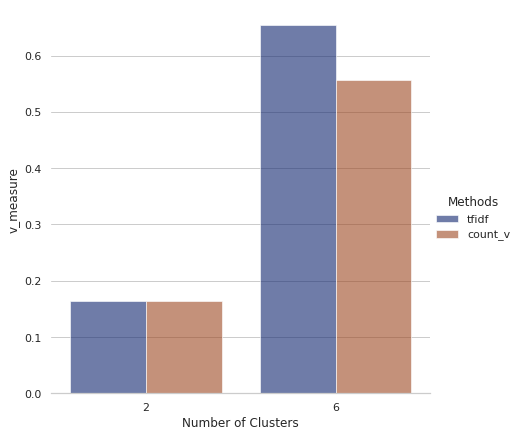

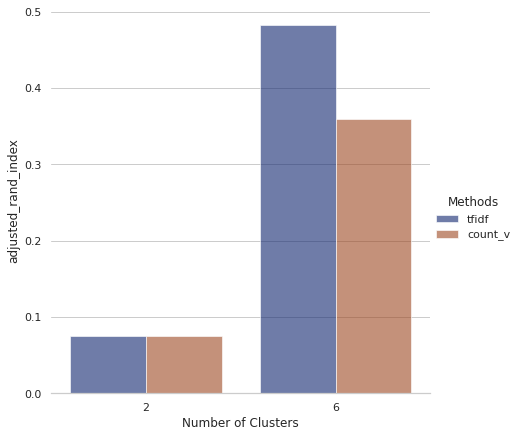

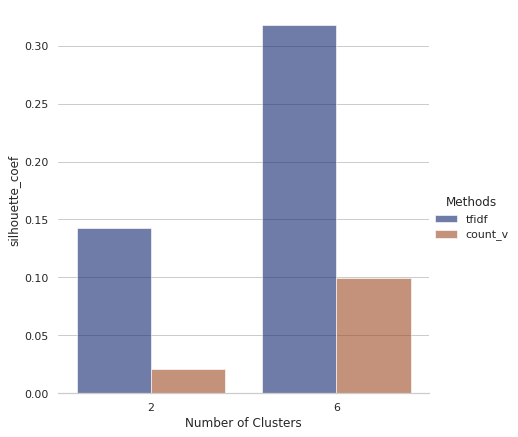

In [55]:
visualise_metrics(data=data, metric_names=metric_names)